# The Glucose Minimal Model

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# download modsim.py if necessary

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ModSimPy/raw/master/modsim.py')

Downloaded modsim.py


In [2]:
# import functions from modsim

from modsim import *

In the previous chapter we implemented the glucose minimal model using given parameters, but I didn't say where those parameters came from.
This notebook solves the mystery.

We'll use a SciPy function called `leastsq`, which stands for "least squares"; that is, it finds the parameters that minimize the sum of squared differences between the results of the model and the data.

You can think of `leastsq` as optional material.  We won't use it in the book itself, but it appears in a few of the case studies.

You can read more about `leastsq` in [the SciPy documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.leastsq.html).  It uses the Levenberg-Marquart algorithm, which you can read about [on Wikipedia](https://en.wikipedia.org/wiki/Levenberg%E2%80%93Marquardt_algorithm).

The following cells download and read the data.

In [3]:
download('https://github.com/AllenDowney/ModSim/raw/main/data/' +
         'glucose_insulin.csv')

Downloaded glucose_insulin.csv


In [4]:
data = pd.read_csv('glucose_insulin.csv', index_col='time');

We'll use `make_system` and `slope_func` as defined in Chapter 18.

In [5]:
download('https://github.com/AllenDowney/ModSimPy/raw/master/' +
         'chap18.py')

Downloaded chap18.py


In [6]:
from chap18 import make_system
from chap18 import slope_func

## Computing errors

In this context, the "errors" are the differences between the results from the model and the data.

To compute the errors, I'll start again with the parameters we used in Chapter 18.

In [7]:
G0 = 270
k1 = 0.02
k2 = 0.02
k3 = 1.5e-05

In [8]:
params = G0, k1, k2, k3

`make_system` takes the parameters and actual data and returns a `System` object.

In [9]:
system = make_system(params, data)

Here's how we run the ODE solver.

In [10]:
results, details = run_solve_ivp(system, slope_func, 
                                 t_eval=data.index)
details.message

'The solver successfully reached the end of the integration interval.'

Because we specify `t_eval=data.index`, the results are evaluated at the some time stamps as the data.

In [11]:
results.tail()

,G,X
102,80.894528,0.003535
122,80.997119,0.001861
142,83.257581,0.000384
162,86.293945,-0.000459
182,89.405110,-0.001178


We can plot the results like this.

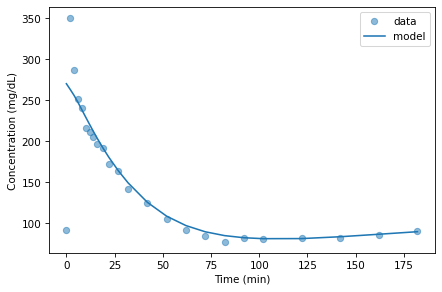

In [12]:
data.glucose.plot(style='o', alpha=0.5, label='data')
results.G.plot(style='-', color='C0', label='model')

decorate(xlabel='Time (min)',
         ylabel='Concentration (mg/dL)')

During the first three time steps, the model does not fit the data. That's because it takes some time for the injected glucose to disperse.

We can compute the errors like this.

In [13]:
errors = results.G - data.glucose
errors.head()

0    178.000000
2    -87.019058
4    -31.316545
6     -3.684558
8     -1.728149
dtype: float64

The first few errors are substantially larger than the rest.

In the next section, we'll use `leastsq` to search for the parameters that minimize the sum of the squared errors.

## Optimization

To use `leastsq`, we need an "error function" that takes a sequence of parameters and returns an array of errors.

Here's a function that does what we need.

In [14]:
def error_func(params, data):
    """Computes an array of errors to be minimized.
    
    params: sequence of parameters
    data: DataFrame of values to be matched
    
    returns: array of errors
    """
    print(params)
    
    # make a System with the given parameters
    system = make_system(params, data)
    
    # solve the ODE
    results, details = run_solve_ivp(system, slope_func, 
                                     t_eval=data.index)
    
    # compute the difference between the model
    # results and actual data
    errors = results.G - data.glucose
    return errors.iloc[3:]

`error_func` uses the given parameters to make a `System` object, runs the simulation, and returns the errors.

But notice that it does not return all of the errors; rather, it uses `iloc` to select only the elements with index 3 or more.
In other words, it omits the elements with index 0, 1, and 2.
Note: You can read more about this use of `iloc` [in the Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-integer).

Since we don't expect the model to fit the data in this regime, we'll leave it out.

We can call `error_func` like this:

In [15]:
error_func(params, data)

(270, 0.02, 0.02, 1.5e-05)


6      -3.684558
8      -1.728149
10     13.294083
12      9.425807
14      6.752546
16      7.353682
19     -0.610979
22      8.260041
27      0.569221
32      6.984791
42      1.228652
52      3.302437
62      4.855592
72      5.283959
82      7.627294
92      0.046105
102    -0.105472
122    -1.002881
142     1.257581
162     1.293945
182    -0.594890
dtype: float64

Now we're ready to call `leastsq`.  As arguments, we pass `error_func`, the parameters where we want to start the search, and the data, which will be passed as an argument to `error_func`.

In [16]:
best_params, fit_details = leastsq(error_func, params, data)

[2.7e+02 2.0e-02 2.0e-02 1.5e-05]
[2.7e+02 2.0e-02 2.0e-02 1.5e-05]
[2.7e+02 2.0e-02 2.0e-02 1.5e-05]
[2.70000004e+02 2.00000000e-02 2.00000000e-02 1.50000000e-05]
[2.70000000e+02 2.00000003e-02 2.00000000e-02 1.50000000e-05]
[2.70000000e+02 2.00000000e-02 2.00000003e-02 1.50000000e-05]
[2.70000000e+02 2.00000000e-02 2.00000000e-02 1.50000002e-05]
[2.71539223e+02 2.40776792e-02 1.85336372e-02 1.31312411e-05]
[2.71539227e+02 2.40776792e-02 1.85336372e-02 1.31312411e-05]
[2.71539223e+02 2.40776796e-02 1.85336372e-02 1.31312411e-05]
[2.71539223e+02 2.40776792e-02 1.85336375e-02 1.31312411e-05]
[2.71539223e+02 2.40776792e-02 1.85336372e-02 1.31312413e-05]
[2.70733829e+02 2.35942255e-02 1.56223467e-02 1.29654857e-05]
[2.70733833e+02 2.35942255e-02 1.56223467e-02 1.29654857e-05]
[2.70733829e+02 2.35942259e-02 1.56223467e-02 1.29654857e-05]
[2.70733829e+02 2.35942255e-02 1.56223469e-02 1.29654857e-05]
[2.70733829e+02 2.35942255e-02 1.56223467e-02 1.29654859e-05]
[2.73718410e+02 2.53505172e-02

Each time `error_func` is called, it prints the parameters, so we can get a sense of how `leastsq` works.

`leastsq` has two return values.
The is an array with the best parameters:

In [17]:
best_params

array([2.71593854e+02, 2.40849547e-02, 1.63029441e-02, 1.27991788e-05])

The second is an object with information about the results, including a success flag and a message.

In [18]:
fit_details.success

True

In [19]:
fit_details.mesg

'The relative error between two consecutive iterates is at most 0.000000'

Now that we have `best_params`, we can use it to make a `System` object and run it.

In [20]:
system2 = make_system(best_params, data)
results2, details = run_solve_ivp(system2, slope_func, 
                                  t_eval=data.index)
details.message

'The solver successfully reached the end of the integration interval.'

Here are the results, along with the data.

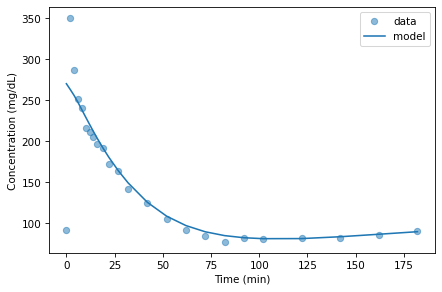

In [21]:
data.glucose.plot(style='o', alpha=0.5, label='data')
results.G.plot(style='-', color='C0', label='model')

decorate(xlabel='Time (min)',
         ylabel='Concentration (mg/dL)')

We can compute the errors like this.

In [22]:
errors2 = results2.G - data.glucose
errors2.head()

0    179.593854
2    -86.885731
4    -32.457099
6     -5.859291
8     -4.873474
dtype: float64

And the sum of the squared errors like this:

In [23]:
from numpy import sum

sum(errors2.iloc[3:]**2)

318.1276841705799

If things have gone according to plan, the sum of squared errors should be smaller now, compared to the parameters we started with.

In [24]:
sum(errors.iloc[3:]**2)

626.244345014139

## Interpreting parameters

So we found the parameters that best match the data.  You might wonder why this is useful.

The parameters themselves don't mean very much, but we can use them to compute two quantities we care about:

-   "Glucose effectiveness", $E$, which is the tendency of elevated
    glucose to cause depletion of glucose.

-   "Insulin sensitivity", $S$, which is the ability of elevated blood
    insulin to enhance glucose effectiveness.

Glucose effectiveness is defined as the change in $dG/dt$ as we vary
$G$: 

$$E \equiv - \frac{\delta \dot{G}}{\delta G}$$ 

where $\dot{G}$ is shorthand for $dG/dt$. Taking the derivative of $dG/dt$ with respect to $G$, we get 

$$E = k_1 + X$$ 

The **glucose effectiveness index**, $S_G$, is the value of $E$ when blood insulin is near its basal level, $I_b$.
In that case, $X$ approaches 0 and $E$ approaches $k_1$. So we can use
the best-fit value of $k_1$ as an estimate of $S_G$.

Insulin sensitivity is defined as the change in $E$ as we vary $I$:

$$S \equiv - \frac{\delta E}{\delta I}$$ 

The **insulin sensitivity index**, $S_I$, is the value of $S$ when $E$ and $I$ are at steady state: 

$$S_I \equiv \frac{\delta E_{SS}}{\delta I_{SS}}$$ 

$E$ and $I$ are at steady state when $dG/dt$ and $dX/dt$ are 0, but we don't actually have to solve those equations to find $S_I$. 

If we set $dX/dt = 0$ and solve for $X$, we find the relation:

$$X_{SS} = \frac{k_3}{k_2} I_{SS}$$ 

And since $E = k_1 + X$, we have:

$$S_I = \frac{\delta E_{SS}}{\delta I_{SS}} = \frac{\delta X_{SS}}{\delta I_{SS}}$$

Taking the derivative of $X_{SS}$ with respect to $I_{SS}$, we have:

$$S_I = k_3 / k_2$$ 

So if we find parameters that make the model fit the data, we can use $k_3 / k_2$ as an estimate of $S_I$.

For the parameters we found, here are the estimated values of $S_G$ and $S_I$:

In [25]:
G0, k1, k2, k3 = best_params
indices = SimpleNamespace(S_G=k1, S_I=k3/k2)
show(indices)

,value
S_G,0.024085
S_I,0.000785


According to [Boston et al](https://www.researchgate.net/publication/8931437_MINMOD_Millennium_A_Computer_Program_to_Calculate_Glucose_Effectiveness_and_Insulin_Sensitivity_From_the_Frequently_Sampled_Intravenous_Glucose_Tolerance_Test), normal ranges for these values are...

In [26]:
S_G_interval = 1.2e-3, 4.5e-2
S_G_interval

(0.0012, 0.045)

In [27]:
S_I_interval = 5.0e-5, 2.2e-3
S_I_interval

(5e-05, 0.0022)

The estimated quantities are within the normal intervals.

## Exercises

**Exercise:** How sensitive are the results to the starting guess for the parameters?  If you try different values for the starting guess, do we get the same values for the best parameters?